## test latency for gstreamer pipeline
```bash
export GST_DEBUG="GST_TRACER:7"
export GST_TRACERS="latency(flags=element+pipeline)"
export GST_DEBUG_FILE=latency.log
 
source /home/icv/Edward/test/sample/install/perception_kit_msgs/share/perception_kit_msgs/local_setup.bash
source /home/icv/Edward/04_tools/analysis_tool/ros2_ws/install/local_setup.bash 
source /home/icv/Edward/04_tools/analysis_tool/ros2_ws/install/adma_msgs/share/adma_msgs/local_setup.bash 
python3.8 ds_3d_det_ros_main.py -i  file:////home/icv/Edward/tools/test_pic_video.mp4
```

1. arch  : sync async thread process
2. GPU driver
3. decode + infer
4. copy data ,GPU,CPU
5. 抽帧 element

https://gstreamer.freedesktop.org/documentation/additional/design/tracing.html?gi-language=c#use-cases
https://unix.stackexchange.com/questions/275647/measuring-latency-in-a-gstreamer-pipeline

Element: qtdemux0, Mean Time: 190.35729777319585, Count: 194
Element: multiqueue0, Mean Time: 972.0564978085107, Count: 188
Element: h264parse0, Mean Time: 0.7483548723404266, Count: 188
Element: capsfilter0, Mean Time: 0.04190083510638297, Count: 188
Element: nvv4l2decoder0, Mean Time: 2621.5344171367533, Count: 117
Element: Stream-muxer, Mean Time: 205.6221285903614, Count: 166
Element: queue1, Mean Time: 565.4788376390535, Count: 169
Element: primary-inference, Mean Time: 283.69682541071444, Count: 168
Element: queue2, Mean Time: 2.190745844311377, Count: 167
Element: nvtiler, Mean Time: 14.880786508982034, Count: 167
Element: queue3, Mean Time: 0.15262664670658688, Count: 167
Element: convertor, Mean Time: 3.0430604431137716, Count: 167
Element: queue4, Mean Time: 0.07323588622754491, Count: 167
Element: onscreendisplay, Mean Time: 0.9112395149700595, Count: 167
Pipeline: source, Mean Time: 4938.398190805555, Count: 108
Element: queue5, Mean Time: 0.07883410179640717, Count: 167


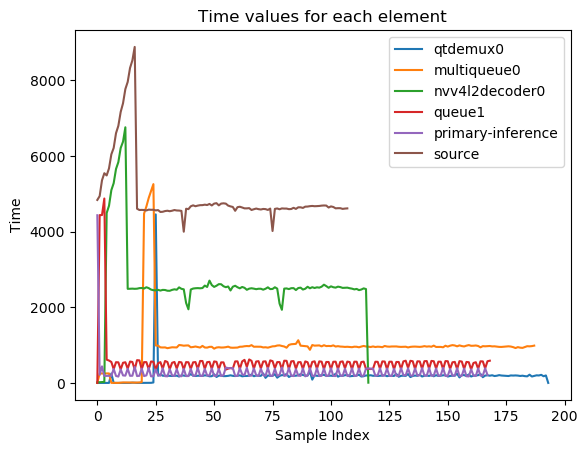

In [1]:
# Offline MP4 stream
import re
from collections import defaultdict
import matplotlib.pyplot as plt


def analyze_time_values_by_element(log_filename):
    with open(log_filename, 'r') as file:
        lines = file.readlines()

    time_values_by_element = defaultdict(list)

    for line in lines:
        # Use a regular expression to find the "element" and "time" attributes and their values
        element_match = re.search(r"element=\(string\)([^,]+),", line)
        time_match = re.search(r"time=\(guint64\)(\d+),", line)

        if element_match and time_match :
            element_value = element_match.group(1)
            time_value_ns = int(time_match.group(1))
            time_value_ms = time_value_ns / 1e6  # Convert nanoseconds to milliseconds
            time_values_by_element[element_value].append(time_value_ms)

    # Calculate statistics for each element
    element_statistics = {element: {"mean": sum(times) / len(times), "count": len(times)} for element, times in time_values_by_element.items()}

    return element_statistics, time_values_by_element

# Example usage
log_filename = 'latency.log'
log_filename = 'latency_map4.log'
element_statistics, time_values_by_element = analyze_time_values_by_element(log_filename)

# Print the element-wise statistics
for element, stats in element_statistics.items():
    if element!='source':
        print(f"Element: {element}, Mean Time: {stats['mean']}, Count: {stats['count']}")
    else:
        print(f"Pipeline: {element}, Mean Time: {stats['mean']}, Count: {stats['count']}")


# Plot the time values for each element
element_filter = ["primary-inference", "queue1","nvv4l2decoder0","source","multiqueue0","qtdemux0"]
for element, times in time_values_by_element.items():
    if element in element_filter:
        plt.plot(times, label=element)

plt.xlabel('Sample Index')
plt.ylabel('Time')
plt.title('Time values for each element')
plt.legend()
plt.show()

In [1]:
# RTSP video stream
import re
from collections import defaultdict
import matplotlib.pyplot as plt


def analyze_time_values_by_element(log_filename):
    with open(log_filename, 'r') as file:
        lines = file.readlines()

    time_values_by_element = defaultdict(list)

    for line in lines:
        # Use a regular expression to find the "element" and "time" attributes and their values
        element_match = re.search(r"element=\(string\)([^,]+),", line)
        time_match = re.search(r"time=\(guint64\)(\d+),", line)

        if element_match and time_match :
            element_value = element_match.group(1)
            time_value_ns = int(time_match.group(1))
            time_value_ms = time_value_ns / 1e6  # Convert nanoseconds to milliseconds
            time_values_by_element[element_value].append(time_value_ms)

            # Break the loop if the maximum samples is reached for the first element
            if len(time_values_by_element[element_value]) == 1000:
                    break

    # Calculate statistics for each element
    element_statistics = {element: {"mean": sum(times) / len(times), "count": len(times)} for element, times in time_values_by_element.items()}

    return element_statistics, time_values_by_element

# Example usage
log_filename = 'latency.log'
element_statistics, time_values_by_element = analyze_time_values_by_element(log_filename)

# Print the element-wise statistics
for element, stats in element_statistics.items():
    if element!='udpsrc0':
        print(f"Element: {element}, Mean Time: {stats['mean']}, Count: {stats['count']}")
    else:
        print(f"Pipeline: {element}, Mean Time: {stats['mean']}, Count: {stats['count']}")

# Plot the time values for each element
element_filter = ["primary-inference", "queue1","nvv4l2decoder0","udpsrc0"]
for element, times in time_values_by_element.items():
    if element in element_filter:
        plt.plot(times, label=element)

plt.xlabel('Sample Index')
plt.ylabel('Time')
plt.title('Time values for each element')
plt.legend()
plt.show()

# src-element=(string)udpsrc0

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/icv/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_125649/2683504346.py", line 35, in <module>
    element_statistics, time_values_by_element = analyze_time_values_by_element(log_filename)
  File "/tmp/ipykernel_125649/2683504346.py", line 8, in analyze_time_values_by_element
    with open(log_filename, 'r') as file:
  File "/home/icv/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 284, in _modified_open
    return io_open(file, *args, **kwargs)
FileNotFoundError: [Errno 2] No such file or directory: 'latency_rtsp.log'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/icv/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  Fi